# NF2FF Jitter with Comparison

Implementing Python version for the jitter experiment (without comparison at first, just for one jitter value). Using the for loop iteration method to account for randomization. Will iterate through the interpolation and transformation 100 times, then take max, min, median, and mean of each error metric across all of the iterations. Then will compare these metrics across a variety of jitter thresholds.

In [54]:
## CLONING the NF2FF Script from MATLAB: https://www.mathworks.com/matlabcentral/fileexchange/23385-nf2ff

## import statements:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2
from numpy.fft import ifft2
from numpy.fft import fftshift
from numpy.fft import ifftshift
from scipy.interpolate import interp2d

from electric_field_errors import *
from NF2FF import *

import pandas
from matplotlib.colors import LogNorm

from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import RegularGridInterpolator

In [55]:
## Specified input parameters from MATLAB folks:
broadcast_freq=94*(10**9) # broadcast frequency in hertz
sdata=np.array(pandas.read_csv('sample_data.csv',header=None)).flatten()
sdata=np.array([complex(x.replace('i','j')) for x in sdata]).reshape((51,51,201))
sdata2=np.array(pandas.read_csv('s21_data2.csv',header=None)).flatten()
sdata2=np.array([complex(x.replace('i','j')) for x in sdata2]).reshape((51,51,201))
freq=np.loadtxt('sample_frequencies.csv',delimiter=',') #Hz
N=len(freq)
f_start=freq[1]
f_stop=freq[-1]
df=(f_stop-f_start)/(N-1)
dt=1.0/(N*df)
t=np.arange(N-1)*dt

# See equations (16-10a) and (16-10b) in Balanis
M=51#sdata.xpoints; # Amount of samples in the x direction (along table, left to right)
N=51#sdata.ypoints; # Amount of samples in the y direction (across table, front to back)
dx=1/1000#sdata.x_step/1000; # Sample spacing in the x direction [m]
dy=1/1000#sdata.y_step/1000; # Sample spacing in the y direction [m]
# See equations (16-10a) and (16-10b) in Balanis
a=dx*(M-1); # The length of the scanned area in the x direction [m]
b=dy*(N-1); # The length of the scanned area in the y direction [m]
x=np.linspace(-a/2,a/2,M)
y=np.linspace(-b/2,b/2,N)
z0=0.006;

[m,n,k_X_Rectangular,k_Y_Rectangular,theta,phi] = RegularGridding(x,y,0.05,0.05)

In [56]:
nyquist_sampling_m = NyquistSampling(broadcast_freq)

In [57]:
def ExtractAmplitudePhase(field):
    amplitude = np.abs(field)
    
    from skimage.restoration import unwrap_phase
    phase = unwrap_phase(np.angle(field),wrap_around=True)
    
    return amplitude, phase

In [58]:
class electric_field_error:
    def __init__(self,original_field,perturbed_field,x,y,label_1,label_2):
        self.original_field = original_field
        self.perturbed_field = perturbed_field
        self.x = x
        self.y = y
        self.xlabel = label_1
        self.ylabel = label_2
    def calculate_error_metrics(self):
        ''''Returns a bunch of metrics in a Python dictionary called error_metrics that quantify the
        error between original_field and perturbed_field. Can also produce output plots if outputs argument
        is set to 1. Meant to be used in conjunction with NF2FF.
        Takes in as inputs two electric fields, and the labels for axes on plots
        x and y are values along the two axes (theta and phi for a far-field pattern)
        set outputs to 1 if want text and plot outputs. 0 (default) supresses outputs
        '''
        
        self.error=self.perturbed_field-self.original_field
        error_real=(self.error).real
        error_im=(self.error).imag
        original_field_real=(self.original_field).real
        original_field_im=(self.original_field).imag
        perturbed_field_real=(self.perturbed_field).real
        perturbed_field_im=(self.perturbed_field).imag
        self.error_amplitude=np.abs(self.error)
        self.error_phase=np.angle(self.error)
        original_field_amplitude=np.abs(self.original_field)
        perturbed_field_amplitude=np.abs(self.perturbed_field)
        original_field_phase=np.angle(self.original_field)
        perturbed_field_phase=np.angle(self.perturbed_field)

        error_real=exclude_7sigma_outliers(error_real)
        error_im=exclude_7sigma_outliers(error_im)

        # calculating weighted percent difference
        # As a vector difference of real and imaginary components
        weighted_percent_difference_real=error_real/((original_field_real+perturbed_field_real)/2)
        weighted_percent_difference_im=error_im/((original_field_im+perturbed_field_im)/2)
        self.weighted_percent_difference= weighted_percent_difference_real + 1j*weighted_percent_difference_im
        self.weighted_percent_difference_amplitude=np.abs(self.weighted_percent_difference)
        self.weighted_percent_difference_phase=np.angle(self.weighted_percent_difference)
        # Method 1 for mean: taking mean of amplitude and phase errors
        self.weighted_percent_difference_amplitude_mean=np.nanmean(self.weighted_percent_difference_amplitude)
        self.weighted_percent_difference_phase_mean=np.nanmean(self.weighted_percent_difference_phase)
        # Method 2: finding mean weighted percent difference by averaging real and imaginary components separately
        weighted_percent_difference_real_mean=np.nanmean(weighted_percent_difference_real)
        weighted_percent_difference_im_mean=np.nanmean(weighted_percent_difference_im)
        self.weighted_percent_difference_mean=weighted_percent_difference_real_mean + 1j*weighted_percent_difference_im_mean
        self.weighted_percent_difference_mean_amplitude=np.abs(self.weighted_percent_difference_mean)
        self.weighted_percent_difference_mean_phase=np.angle(self.weighted_percent_difference_mean)

        # range of the error--calculated as max - min of the error (complex subtraction between the two fields)
        error_range_real=np.nanmax(error_real)-np.nanmin(error_real)
        error_range_im=np.nanmax(error_im)-np.nanmin(error_im)
        self.error_range=error_range_real + 1j*error_range_im
        self.error_range_amplitude=np.abs(self.error_range)
        self.error_range_phase=np.angle(self.error_range)
        # doing the same for the weighted percent difference
        pct_difference_range_real=np.nanmax(weighted_percent_difference_real) - np.nanmin(weighted_percent_difference_real)
        pct_difference_range_im = np.nanmax(weighted_percent_difference_im) - np.nanmin(weighted_percent_difference_im)
        self.pct_difference_range = pct_difference_range_real + 1j*pct_difference_range_im
        self.pct_difference_range_amplitude = np.abs(self.pct_difference_range)
        self.pct_difference_range_phase = np.angle(self.pct_difference_range)

        # standard deviation of the error
        std_error_real=np.nanstd(error_real)
        std_error_im=np.nanstd(error_im)
        self.std_error = std_error_real + 1j*std_error_im
        self.std_error_amplitude = np.abs(self.std_error)
        self.std_error_phase = np.angle(self.std_error)
        # standard deviation of the percent error
        pct_diff_std_error_real = np.nanstd(weighted_percent_difference_real)
        pct_diff_std_error_im = np.nanstd(weighted_percent_difference_im)
        self.pct_diff_std_error = pct_diff_std_error_real + 1j*pct_diff_std_error_im
        self.pct_diff_std_error_amplitude = np.abs(self.pct_diff_std_error)
        self.pct_diff_std_error_phase = np.angle(self.pct_diff_std_error)

        # overall magnitude of the error: abs(original) - abs(perturbed)
        self.error_magnitudes = np.abs(self.original_field) - np.abs(self.perturbed_field)
        self.error_magnitudes_mean = np.nanmean(self.error_magnitudes)
        self.pct_error_magnitudes = np.divide(self.error_magnitudes,(np.abs(self.original_field) + np.abs(self.perturbed_field))/2)
        self.pct_error_magnitudes_mean = np.nanmean(self.pct_error_magnitudes)

        # excluding data beyond the main beam to calculate the fractional solid angle error
        dB_cutoff = -145 # this is the cutoff for the sample data provided with the MATLAB script
        power_cutoff = 10**(dB_cutoff/20)
        original_excluded_indices = original_field_amplitude < power_cutoff
        original_field_amplitude[original_excluded_indices] = float('nan')
        original_field_real[original_excluded_indices] = float('nan')
        original_field_im[original_excluded_indices] = float('nan')
        perturbed_excluded_indices = perturbed_field_amplitude < power_cutoff
        perturbed_field_amplitude[perturbed_excluded_indices] = float('nan')
        perturbed_field_real[perturbed_excluded_indices] = float('nan')
        perturbed_field_im[perturbed_excluded_indices] = float('nan')

        # calculating fractional change in solid angle for the excluded data set
        solid_angle_original = np.nansum(original_field_amplitude)
        solid_angle_perturbed = np.nansum(perturbed_field_amplitude)
        self.solid_angle_error_fraction = np.abs((solid_angle_original - solid_angle_perturbed)/solid_angle_original)
        
    def output_error_metrics(self):
        fig,ax=subplots(1,2,constrained_layout=True,figsize=(17,10))
        pcm=ax[0].pcolormesh(self.x,self.y,self.error_amplitude)
        ax[0].set_aspect('equal')
        ax[0].set_title('Difference between perturbed and original fields: amplitude')
        ax[0].set_xlabel(self.xlabel)
        ax[0].set_ylabel(self.ylabel)
        colorbar(mappable=pcm,ax=ax[0],shrink=0.7)
        pcm=ax[1].pcolormesh(self.x,self.y,self.error_phase)
        ax[1].set_aspect('equal')
        ax[1].set_title('Difference between perturbed and original fields: phase')
        ax[1].set_xlabel(self.xlabel)
        ax[1].set_ylabel(self.ylabel)
        colorbar(mappable=pcm,ax=ax[1],shrink=0.7)

        # plotting percent difference over the entire 2D grid
        fig,ax=subplots()
        pcolor(self.x,self.y,self.weighted_percent_difference_amplitude,vmax=1)
        ax.set_aspect('equal')
        ax.set_xlabel(self.xlabel)
        ax.set_ylabel(self.ylabel)
        ax.set_title('Weighted percent difference: amplitude')
        colorbar()

        # print statements
        print('Amplitude and phase of mean weighted percent difference (vector form): {}, {}'.format(self.weighted_percent_difference_mean_amplitude,self.weighted_percent_difference_mean_phase))
        print('Mean weighted percent difference in amplitude and phase: {}, {}'.format(self.weighted_percent_difference_amplitude_mean,self.weighted_percent_difference_phase_mean))
        print('Amplitude and phase of error range: {}, {}'.format(self.error_range_amplitude,self.error_range_phase))
        print('Amplitude and phase of percent difference range: {}, {}'.format(self.pct_difference_range_amplitude,self.pct_difference_range_phase))
        print('Amplitude and phase of standard deviation of the error: {}, {}'.format(self.std_error_amplitude,self.std_error_phase))
        print('Amplitude and phase of standard deviation of percent error: {}, {}'.format(self.pct_diff_std_error_amplitude,self.pct_diff_std_error_phase))
        print('Mean of amplitude(b1) - amplitude(b2): {}'.format(self.error_magnitudes_mean))
        print('Mean of pct difference amplitude metric: {}'.format(self.pct_error_magnitudes_mean))
        print('Solid angle error fraction (excluded): {}'.format(self.solid_angle_error_fraction))

class all_electric_field_errors:
    def __init__(self):
        self.pct_diff_amplitude_means = []
        self.pct_diff_mean_amplitudes = []
        self.error_range_amplitudes = []
        self.error_range_phases = []
        self.pct_diff_range_amplitudes = []
        self.std_error_amplitudes = []
        self.pct_diff_std_error_amplitudes = []
        self.error_magnitudes_means = []
        self.pct_error_magnitudes_means = []
        self.solid_angle_error_fractions = []
    def append(self,electric_field_errors):
        (self.pct_diff_amplitude_means).append(electric_field_errors.weighted_percent_difference_amplitude_mean)
        (self.pct_diff_mean_amplitudes).append(electric_field_errors.weighted_percent_difference_mean_amplitude)
        (self.error_range_amplitudes).append(electric_field_errors.error_range_amplitude)
        (self.error_range_phases).append(electric_field_errors.error_range_phase)
        (self.pct_diff_range_amplitudes).append(electric_field_errors.pct_difference_range_amplitude)
        (self.error_magnitudes_means).append(electric_field_errors.error_magnitudes_mean)
        (self.solid_angle_error_fractions).append(electric_field_errors.solid_angle_error_fraction)
    def calculate_metrics(self):
        all_errors = [self.pct_diff_amplitude_means,self.pct_diff_mean_amplitudes,self.error_range_amplitudes,\
                     self.error_range_phases,self.pct_diff_range_amplitudes,self.error_magnitudes_means,self.solid_angle_error_fractions]
        error_means = np.mean(all_errors,axis=1)
        error_medians = np.median(all_errors,axis=1)
        error_maxes = np.max(all_errors,axis=1)
        
        self.mean_pct_diff_amplitude_mean = error_means[0]
        self.median_pct_diff_amplitude_mean = error_medians[0]
        self.max_pct_diff_amplitude_mean = error_maxes[0]
        self.mean_pct_diff_mean_amplitude = error_means[1]
        self.median_pct_diff_mean_amplitude = error_medians[1]
        self.max_pct_diff_mean_amplitude = error_maxes[1]
        self.mean_error_range_amplitude = error_means[2]
        self.median_error_range_amplitude = error_medians[2]
        self.max_error_range_amplitude = error_maxes[2]
        self.mean_error_range_phase = error_means[3]
        self.median_error_range_phase = error_medians[3]
        self.max_error_range_phase = error_maxes[3]
        self.mean_pct_diff_range_amplitude = error_means[4]
        self.median_pct_diff_range_amplitude = error_medians[4]
        self.max_pct_diff_range_amplitude = error_maxes[4]
        self.mean_error_magnitudes_mean = error_means[5]
        self.median_error_magnitudes_mean = error_medians[5]
        self.max_error_magnitudes_mean = error_maxes[5]
        self.mean_solid_angle_error_fraction = error_means[6]
        self.median_solid_angle_error_fraction = error_medians[6]
        self.max_solid_angle_error_fraction = error_maxes[6]
        
    def output_metrics(self):
        print("Mean amplitude of mean percent differences (complex): {}".format(self.mean_pct_diff_mean_amplitude))
        print("Median amplitude of mean percent differences: {}".format(self.median_pct_diff_mean_amplitude))
        print("Max amplitude of mean percent differences: {}".format(self.max_pct_diff_mean_amplitude))
        print("Mean of mean percent difference in amplitude: {}".format(self.mean_pct_diff_amplitude_mean))
        print("Median of mean percent difference in amplitude: {}".format(self.mean_pct_diff_amplitude_mean))
        print("Max of mean percent difference in amplitude: {}".format(self.mean_pct_diff_amplitude_mean))
        print("Mean of error range amplitudes: {}".format(self.mean_error_range_amplitude))
        print("Median of error range amplitudes: {}".format(self.median_error_range_amplitude))
        print("Max of error range amplitudes: {}".format(self.max_error_range_amplitude))
        print("Mean of error range phases: {}".format(self.mean_error_range_phase))
        print("Median of error range phases: {}".format(self.median_error_range_phase))
        print("Max of error range phases: {}".format(self.max_error_range_phase))
        print("Mean of percent difference range amplitudes: {}".format(self.mean_pct_diff_range_amplitude))
        print("Median of percent difference range amplitudes: {}".format(self.median_pct_diff_range_amplitude))
        print("Max of percent difference range amplitudes: {}".format(self.max_pct_diff_range_amplitude))
        print("Mean of mean error magnitudes: {}".format(self.mean_error_magnitudes_mean))
        print("Median of mean error magnitudes: {}".format(self.median_error_magnitudes_mean))
        print("Max of mean error magnitudes: {}".format(self.max_error_magnitudes_mean))
        print("Mean of solid angle error fractions: {}".format(self.mean_solid_angle_error_fraction))
        print("Median of solid angle error fractions: {}".format(self.median_solid_angle_error_fraction))
        print("Max of solid angle error fractions: {}".format(self.max_solid_angle_error_fraction))

In [59]:
# reading NF data into grid
find=200
f=freq[find];print(f*1e-9)
k0 = Calculate_k0(f)
NF_X_Complex=sdata[:,:,find]
NF_Y_Complex=sdata2[:,:,find]
NF_X_Magnitude = (np.abs(NF_X_Complex));
NF_Y_Magnitude = (np.abs(NF_Y_Complex));
from skimage.restoration import unwrap_phase
NF_X_Phase=unwrap_phase(np.angle(NF_X_Complex),wrap_around=True)
NF_Y_Phase=unwrap_phase(np.angle(NF_Y_Complex),wrap_around=True)

NF_X_Magnitude, NF_X_Phase = ExtractAmplitudePhase(NF_X_Complex)
NF_Y_Magnitude, NF_Y_Phase = ExtractAmplitudePhase(NF_Y_Complex)

110.0


In [60]:
# performing transformation on non-perturbed NF data
FourierSpace = NFtoFourier(NF_X_Complex,NF_Y_Complex,k_X_Rectangular,k_Y_Rectangular,k0)
[Etheta,Ephi] = FouriertoFF(FourierSpace[0],FourierSpace[1],FourierSpace[2],theta,phi,k_X_Rectangular,k_Y_Rectangular,k0)

In [61]:
# calculating jitter threshold
jitter_percentage_thresholds=np.array([0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,1/15,0.1,0.125,0.15,0.175,0.2])
jitter_thresholds = nyquist_sampling_m*jitter_percentage_thresholds

In [62]:
all_Etheta_errors = [all_electric_field_errors() for jitter in jitter_thresholds]
all_Ephi_errors = [all_electric_field_errors() for jitter in jitter_thresholds]

In [63]:
for i_jitter in range(len(jitter_thresholds)):
    for i_iteration in range(1000):
        jitter_x = -jitter_thresholds[i_jitter] + 2*jitter_thresholds[i_jitter]*np.random.rand(1,M)
        jitter_y = -jitter_thresholds[i_jitter] + 2*jitter_thresholds[i_jitter]*np.random.rand(1,N)
        x_jittered = x + jitter_x
        y_jittered = y + jitter_y
        [x_jittered_grid,y_jittered_grid] = np.meshgrid(x_jittered,y_jittered)

        # interpolating near-field data to obtain jittered near-field data
        # must do real and imaginary components separately
        NF_X_interp_real = RectBivariateSpline(x,y,NF_X_Complex.real)
        NF_X_interp_im = RectBivariateSpline(x,y,NF_X_Complex.imag)
        NF_Y_interp_real = RectBivariateSpline(x,y,NF_Y_Complex.real)
        NF_Y_interp_im = RectBivariateSpline(x,y,NF_Y_Complex.imag)

        # evaluating interpolation functions over jittered grid
        NF_X_jittered_real = NF_X_interp_real(x_jittered,y_jittered)
        NF_X_jittered_im = NF_X_interp_im(x_jittered,y_jittered)
        NF_X_jittered = NF_X_jittered_real + 1j*NF_X_jittered_im
        NF_Y_jittered_real = NF_Y_interp_real(x_jittered,y_jittered)
        NF_Y_jittered_im = NF_Y_interp_im(x_jittered,y_jittered)
        NF_Y_jittered = NF_Y_jittered_real + 1j*NF_Y_jittered_im

        FourierSpace_jittered = NFtoFourier(NF_X_jittered,NF_Y_jittered,k_X_Rectangular,k_Y_Rectangular,k0)
        [Etheta_jittered,Ephi_jittered] = FouriertoFF(FourierSpace_jittered[0],FourierSpace_jittered[1],FourierSpace_jittered[2],theta,phi,k_X_Rectangular,k_Y_Rectangular,k0)

        Etheta_error_metrics = electric_field_error(Etheta,Etheta_jittered,theta,phi,'theta','phi')
        Etheta_error_metrics.calculate_error_metrics()
        Ephi_error_metrics = electric_field_error(Ephi,Ephi_jittered,theta,phi,'theta','phi')
        Ephi_error_metrics.calculate_error_metrics()
        
        (all_Etheta_errors[i_jitter]).append(Etheta_error_metrics)
        (all_Ephi_errors[i_jitter]).append(Ephi_error_metrics)
        (all_Etheta_errors[i_jitter]).calculate_metrics()
        (all_Ephi_errors[i_jitter]).calculate_metrics()
    


Etheta solid angle cutoff: 0.22374922055148236
Ephi solid angle cutoff: 0.17541937600217947


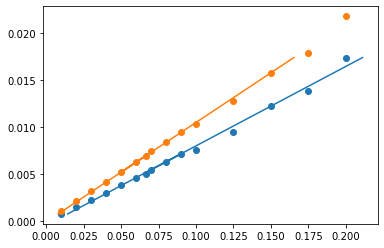

In [64]:
Etheta_mean_solid_angle = [errors.mean_solid_angle_error_fraction for errors in all_Etheta_errors]
Ephi_mean_solid_angle = [errors.mean_solid_angle_error_fraction for errors in all_Ephi_errors]

Etheta_solid_angle_fits = np.polyfit(Etheta_mean_solid_angle,jitter_percentage_thresholds,1)
Ephi_solid_angle_fits = np.polyfit(Ephi_mean_solid_angle,jitter_percentage_thresholds,1)
Etheta_solid_angle_cutoff = np.polyval(Etheta_solid_angle_fits,0.018435)
Ephi_solid_angle_cutoff = np.polyval(Ephi_solid_angle_fits,0.018435)

print('Etheta solid angle cutoff: {}'.format(Etheta_solid_angle_cutoff))
print('Ephi solid angle cutoff: {}'.format(Ephi_solid_angle_cutoff))

plt.scatter(jitter_percentage_thresholds,Etheta_mean_solid_angle,label='Etheta')
plt.scatter(jitter_percentage_thresholds,Ephi_mean_solid_angle,label='Ephi')
plt.plot(np.polyval(Etheta_solid_angle_fits,Etheta_mean_solid_angle),Etheta_mean_solid_angle)
plt.plot(np.polyval(Ephi_solid_angle_fits,Etheta_mean_solid_angle),Etheta_mean_solid_angle)

In [65]:
help(np.polyfit)

Help on function polyfit in module numpy:

polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
    Least squares polynomial fit.
    
    .. note::
       This forms part of the old polynomial API. Since version 1.4, the
       new polynomial API defined in `numpy.polynomial` is preferred.
       A summary of the differences can be found in the
       :doc:`transition guide </reference/routines.polynomials>`.
    
    Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
    to points `(x, y)`. Returns a vector of coefficients `p` that minimises
    the squared error in the order `deg`, `deg-1`, ... `0`.
    
    The `Polynomial.fit <numpy.polynomial.polynomial.Polynomial.fit>` class
    method is recommended for new code as it is more stable numerically. See
    the documentation of the method for more information.
    
    Parameters
    ----------
    x : array_like, shape (M,)
        x-coordinates of the M sample points ``(x[i], y[i])``.
    y : array_